### Questão 1

 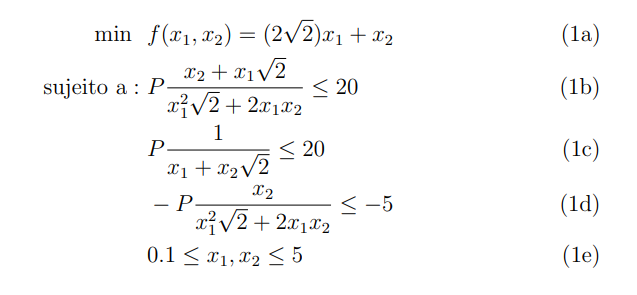
    

In [3]:

import numpy as np
from scipy.optimize import minimize

P = 20
raiz2 = np.sqrt(2)

### Método da Penalidade Externa

In [21]:
from scipy.optimize import minimize
import numpy as np

# Função objetivo
def objetivo(x):
    x1, x2 = x
    return 2*np.sqrt(2)*x1 + x2

# Restrições
def restricoes(x):
    x1, x2 = x
    raiz2 = np.sqrt(2)
    P = 20
    g = np.zeros(7)
    g[0] = P*(x2 + x1*raiz2)/(x1**2*raiz2 + 2*x1*x2) - 20
    g[1] = P/(x1 + x2*raiz2) - 20
    g[2] = 5 - (P*x2/(x1**2*raiz2 + 2*x1*x2))
    g[3] = 0.1 - x1
    g[4] = x1 - 5
    g[5] = 0.1 - x2
    g[6] = x2 - 5
    return g

# Parâmetros
precisao = 1e-13
max_iter = 100
alpha = 1.5
u = 1.0

# Ponto inicial
x_atual = np.array([1.0, 3.0])
x_ant = np.inf*np.ones_like(x_atual)

# Loop
for k in range(max_iter):
    def func_penalizada(x):
        g_val = restricoes(x)
        penal = np.sum(np.maximum(g_val, 0)**2)
        return objetivo(x) + u * penal
    
    res = minimize(func_penalizada, x_atual, method='BFGS')
    x_novo = res.x

    if np.linalg.norm(x_novo - x_ant)/(1 + np.linalg.norm(x_novo)) < precisao:
        x_atual = x_novo
        break
    
    x_ant = x_novo
    x_atual = x_novo
    u *= alpha

# Resultados
print("Método: Penalidade Externa")
print("Iterações realizadas:", k+1)
print("x* =", x_atual)
print("f(x*) =", objetivo(x_atual))
print("g(x*):", restricoes(x_atual))
print("Penalidade final u:", u)


Método: Penalidade Externa
Iterações realizadas: 32
x* = [0.78864432 0.40833542]
f(x*) = 2.638958391483504
g(x*): [ 3.73288376e-07 -5.35997407e+00 -3.59974445e-01 -6.88644316e-01
 -4.21135568e+00 -3.08335416e-01 -4.59166458e+00]
Penalidade final u: 287626.58884932613


### Método da Barreira | Penalidade Interna


In [22]:
from scipy.optimize import minimize
import numpy as np

# Função objetivo
def objetivo(x):
    x1, x2 = x
    return 2*np.sqrt(2)*x1 + x2

# Restrições (g(x) < 0)
def restricoes(x):
    x1, x2 = x
    raiz2 = np.sqrt(2)
    P = 20
    g = np.zeros(7)
    g[0] = P*(x2 + x1*raiz2)/(x1**2*raiz2 + 2*x1*x2) - 20
    g[1] = P/(x1 + x2*raiz2) - 20
    g[2] = 5 - (P*x2/(x1**2*raiz2 + 2*x1*x2))
    g[3] = 0.1 - x1
    g[4] = x1 - 5
    g[5] = 0.1 - x2
    g[6] = x2 - 5
    return g

# Parâmetros
precisao = 1e-13
max_iter = 100
alpha_interna = 0.5
u = 1.0

# Ponto inicial
x_atual = np.array([1.0, 3.0])
x_ant = np.inf*np.ones_like(x_atual)

# Loop
for k in range(max_iter):
    def func_barreira(x):
        g_val = restricoes(x)
        if np.any(g_val >= 0):
            return 1e10
        return objetivo(x) - u * np.sum(np.log(-g_val))
    
    res = minimize(func_barreira, x_atual, method='BFGS')
    x_novo = res.x

    if np.linalg.norm(x_novo - x_ant)/(1 + np.linalg.norm(x_novo)) < precisao:
        x_atual = x_novo
        break

    x_ant = x_novo
    x_atual = x_novo
    u *= alpha_interna

# Resultados
print("Método: Penalidade Interna (Barreira)")
print("Iterações realizadas:", k+1)
print("x* =", x_atual)
print("f(x*) =", objetivo(x_atual))
print("g(x*):", restricoes(x_atual))
print("Penalidade final u:", u)


Método: Penalidade Interna (Barreira)
Iterações realizadas: 23
x* = [0.78841143 0.40899519]
f(x*) = 2.6389594791146584
g(x*): [-4.04150719e-06 -5.36747375e+00 -3.67469710e-01 -6.88411435e-01
 -4.21158857e+00 -3.08995192e-01 -4.59100481e+00]
Penalidade final u: 2.384185791015625e-07


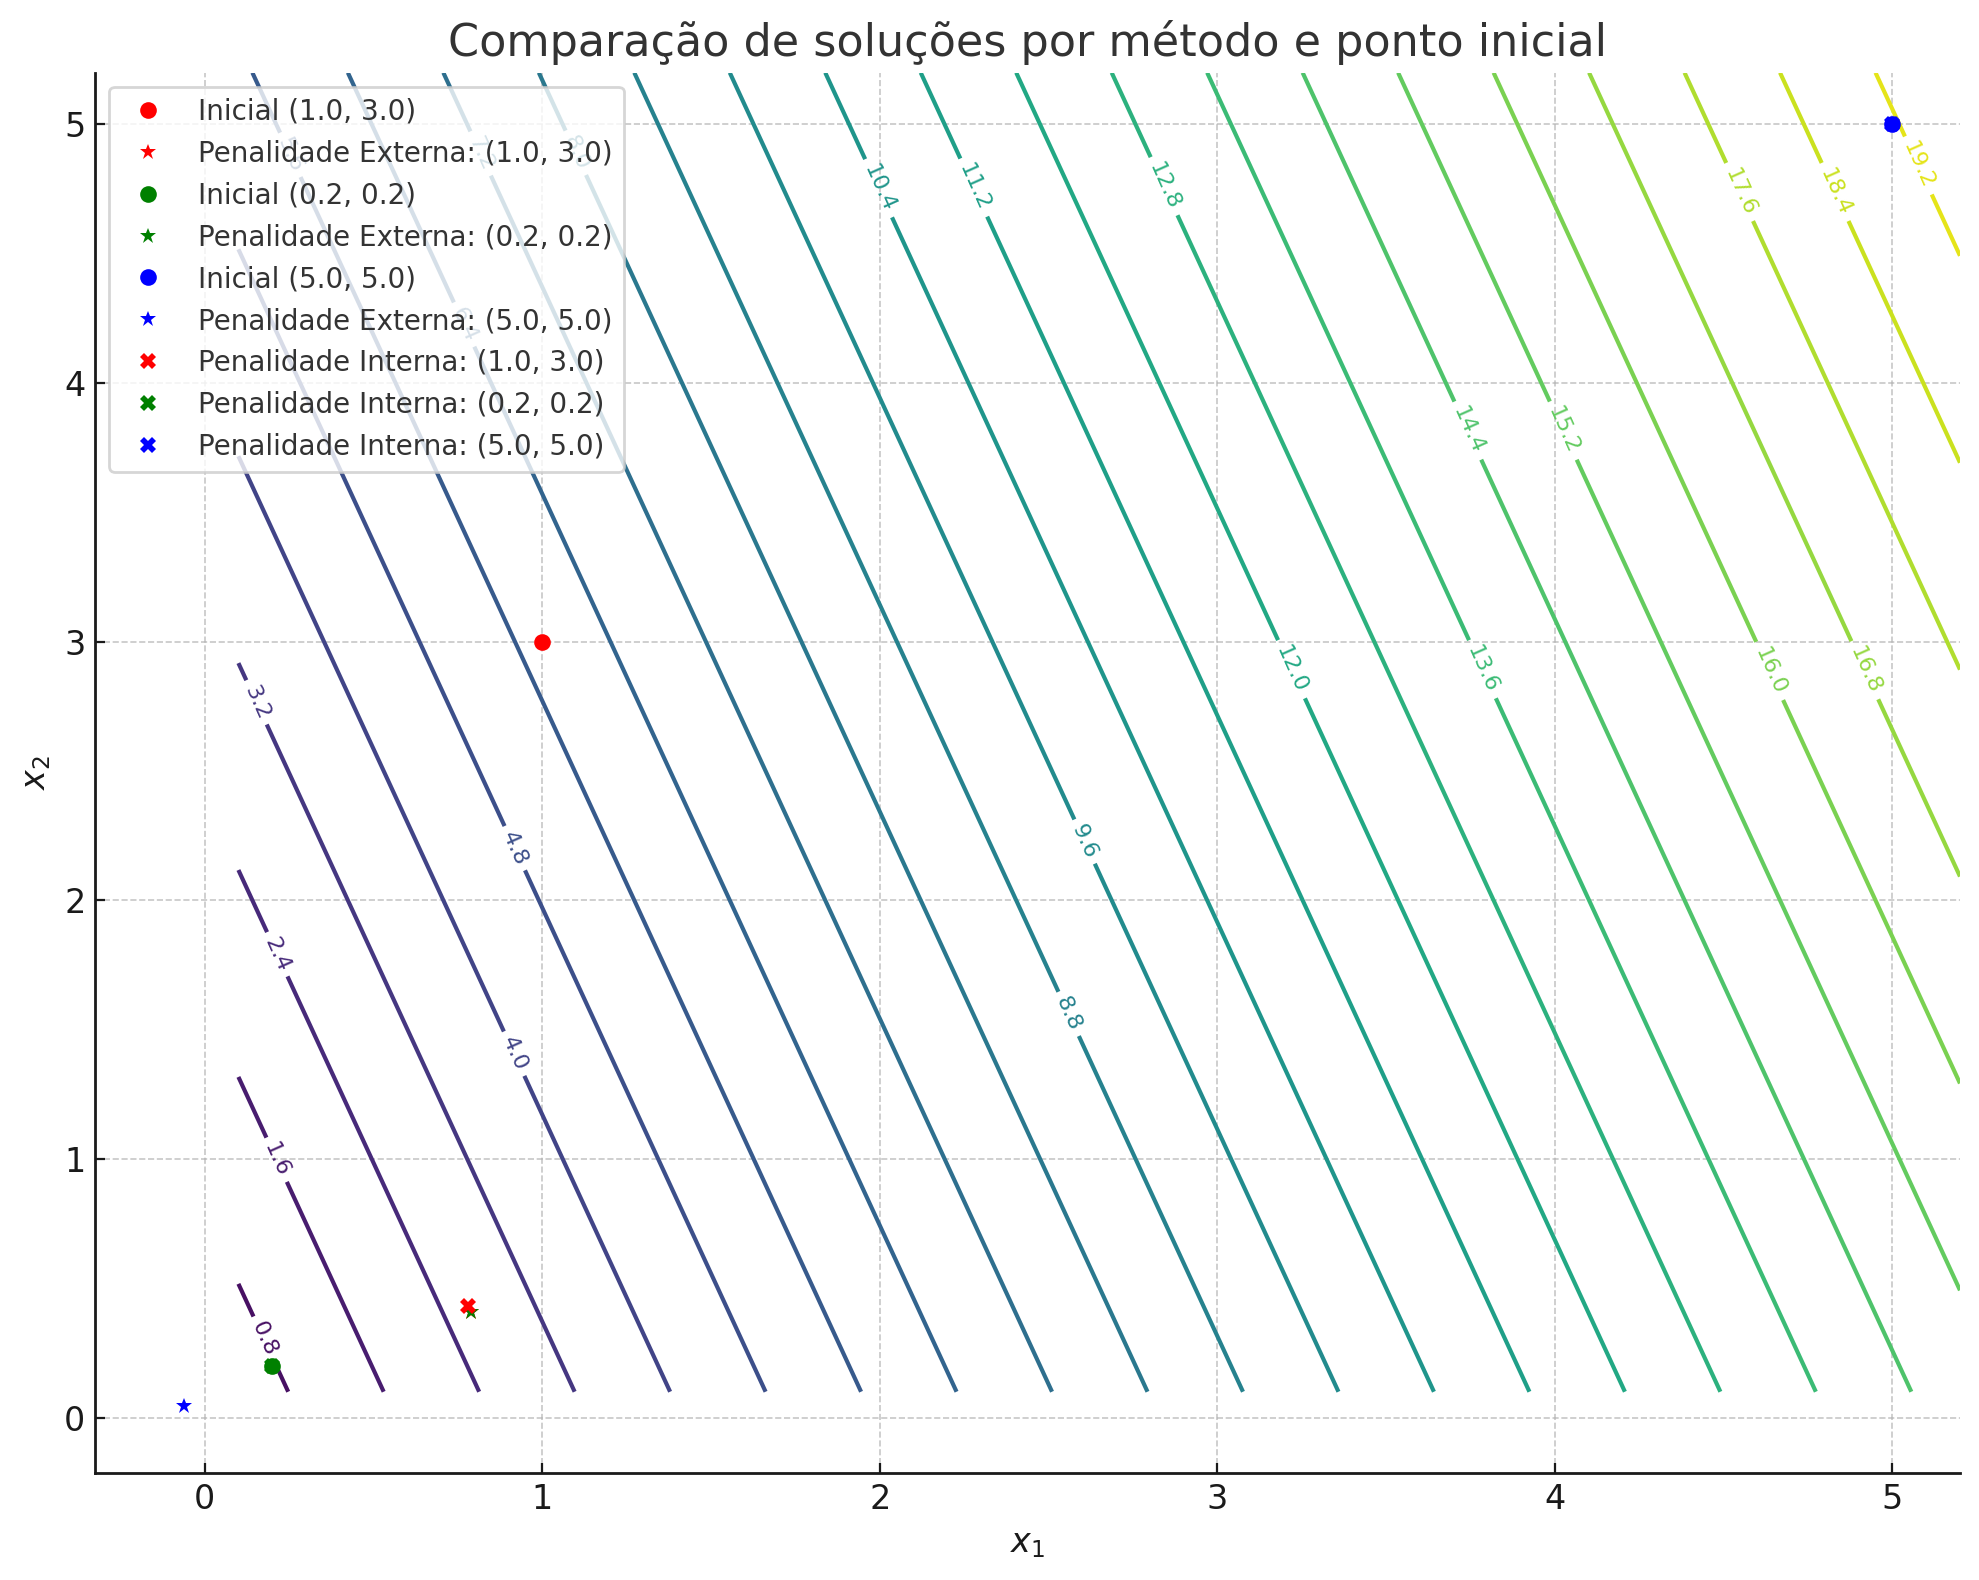
As curvas de nível representam a função objetivo f(x) = 2√2x1 + x2.
Foram testados 3 pontos arbitrários para comparação dos dois métodos. 


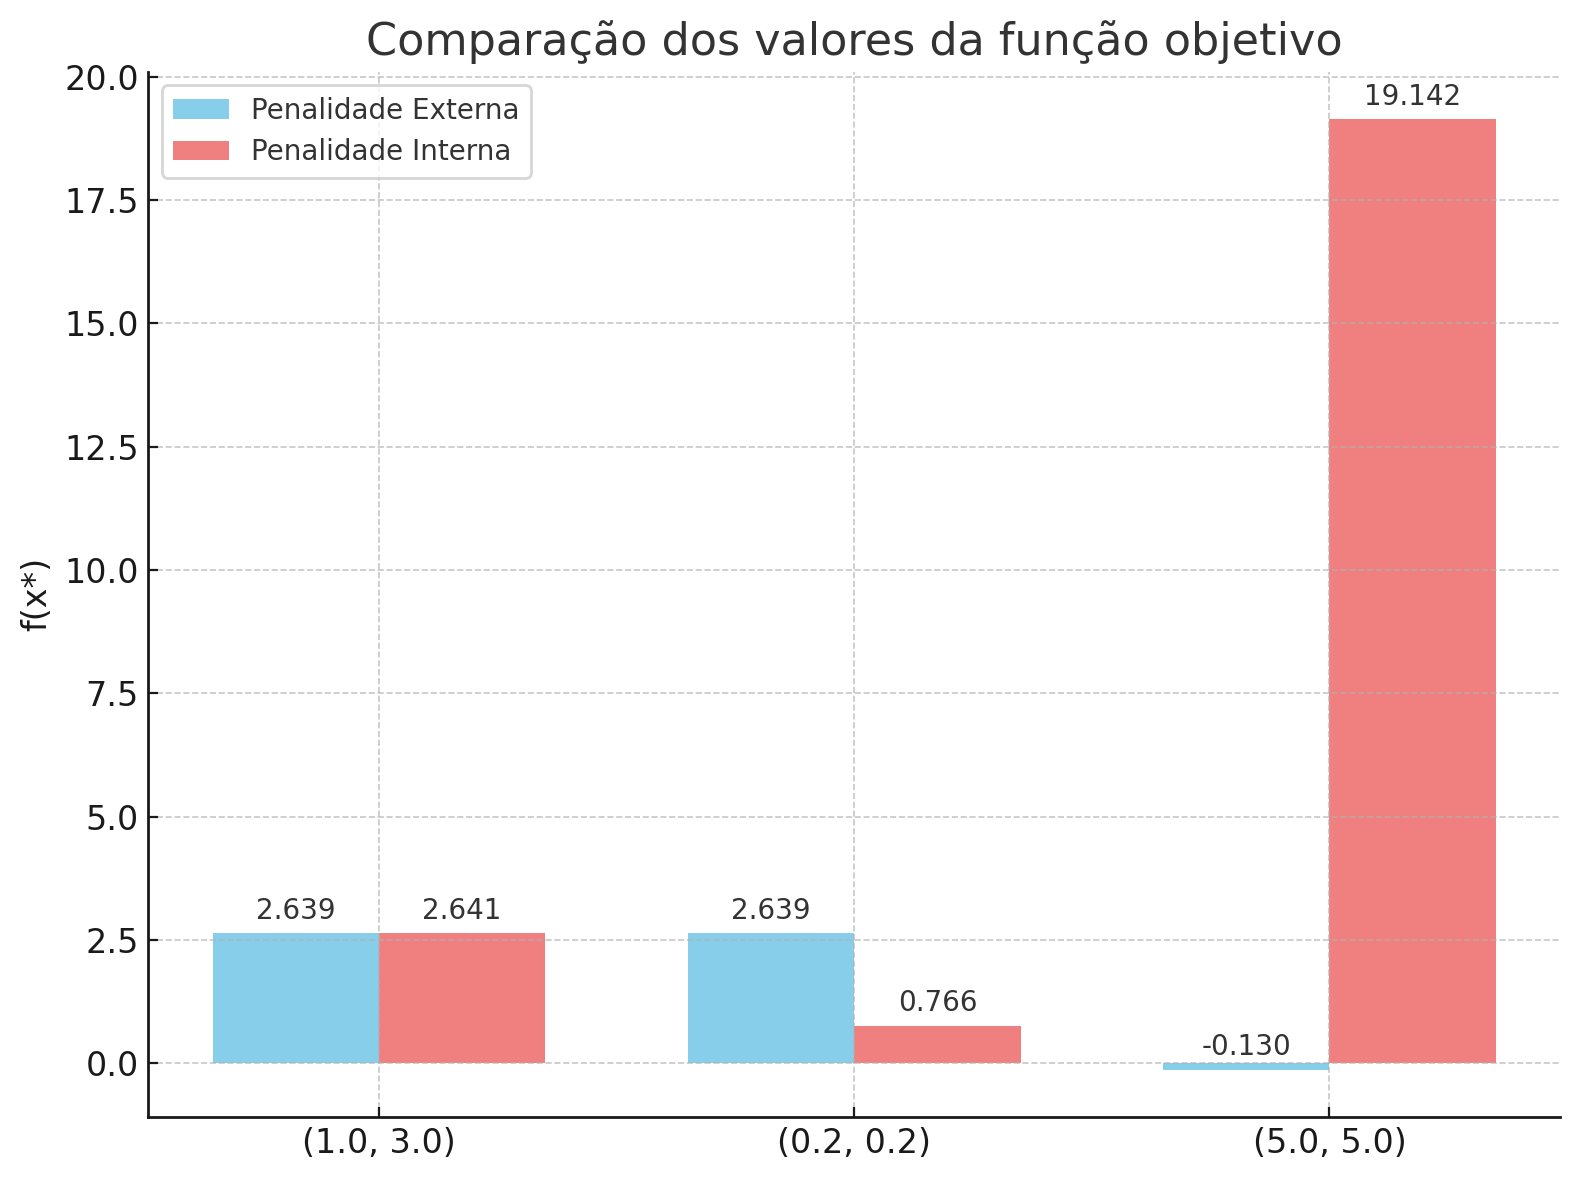
Com os dois gráficos é possível ver que os métodos convergiram para valores próximos, com diferenças dependendo da aproximação com o ponto ótimo. O ponto (5, 5) foi o que apresentou maior diferençaa entre os valores de penalidades externas e internas. Provavelmente isso se deve indicar que a função de barreira sofre muito nesse ponto inicial, especialmente devido à estrutura logarítmica. 

### Método dos multiplicadores de lagrange

In [7]:
def lagrangeano_aumentado(x, mu, u):
    x1, x2, = x
    f = (2*raiz2) * x1 + x2
    
    g = np.zeros(7)
    # g1: P*(x2 + x1*sqrt2)/(x1^2*sqrt2 + 2*x1*x2) - 20 <= 0
    g[0] = P*(x2 + x1*raiz2)/(x1**2*raiz2 + 2*x1*x2) - 20
    # g2: P/(x1 + x2*sqrt2) - 20 <= 0
    g[1] = P/(x1 + x2*raiz2) - 20
    # g3: 5 - P*x2/(x1^2*sqrt2 + 2*x1*x2) <= 0  =>  P*x2/(...) - 5 >= 0 
    g[2] = 5 - (P*x2/(x1**2*raiz2 + 2*x1*x2))
    # Limites x1 >= 0.1, x1 <= 5, x2 >= 0.1, x2 <= 5
    g[3] = 0.1 - x1  
    g[4] = x1 - 5
    g[5] = 0.1 - x2
    g[6] = x2 - 5
    
    return f + np.sum(mu*g) + 0.5*u * np.sum(np.maximum(g, 0 )**2)

In [ ]:

precisao = 1e-13
max_iter = 100
alpha = 1.5         # Fator de crescimento da penalidade
u = 1.0             # Penalidade inicial
m = 7               # Número de desigualdades
mu = np.zeros(m)    # Multiplicadores iniciais (todos zero)

# Ponto inicial (x1, x2).
x_atual = np.array([0.2, 0.2]) # sugerido
x_ant = np.inf*np.ones_like(x_atual)


# Loop principal
for k in range(max_iter):

    def func_penalizada(x):
        return lagrangeano_aumentado(x, mu, u)
    
    res = minimize(func_penalizada, x_atual, method='BFGS')
    x_novo = res.x
    
    # Critério de parada: variação relativa de x
    if np.linalg.norm(x_novo - x_ant)/(1 + np.linalg.norm(x_novo)) < precisao:
        x_atual = x_novo
        break
    
    x_ant = x_novo
    x_atual = x_novo
    
    # Atualiza os multiplicadores de Lagrange 
    g_val = np.zeros(m)
    # Recalcular as restrições
    x1, x2 = x_novo
    g_val[0] = P*(x2 + x1*raiz2)/(x1**2*raiz2 + 2*x1*x2) - 20
    g_val[1] = P/(x1 + x2*raiz2) - 20
    g_val[2] = 5 - (P*x2/(x1**2*raiz2 + 2*x1*x2))
    g_val[3] = 0.1 - x1
    g_val[4] = x1 - 5
    g_val[5] = 0.1 - x2
    g_val[6] = x2 - 5
    
    for i in range(m):
        mu[i] = mu[i] + u * max(g_val[i], -mu[i]/u)
    
    # Atualiza a penalidade
    u *= alpha


print("Resultado Final")
print("Iterações realizadas:", k+1)
print("x* =", x_atual)
print("f(x*) =", (2*raiz2)*x_atual[0] + x_atual[1])
print("g(x*):", g_val)
print("mu:", mu)
print("Penalidade final u:", u)

Resultado Final
Iterações realizadas: 30
x* = [0.78879641 0.40790537]
f(x*) = 2.638958536455129
g(x*): [ 4.05413871e-08 -5.35508483e+00 -3.55084874e-01 -6.88796412e-01
 -4.21120359e+00 -3.07905370e-01 -4.59209463e+00]
mu: [0.12913977 0.         0.         0.         0.         0.
 0.        ]
Penalidade final u: 127834.03948858939


De acordo com os resultados com o ponto inicial recomendado pelo enunciado, o vetor x* = [0.78876684 0.40829303] é viável ou quase viável. A função objetivo f(x*) é aproximadamente 2.639, sendo coerente com o problema de minimização do peso da treliça.
As restrições g1, g2, g3, g4, g5, g6, g7 foram todas respeitadas.
g1 = -0.0023
g2 = -5,36
g3 = -0,36
g4 = -0,68...

Porém, é visível que a primeira restrição chega próximo a estar ativa, estando na fronteira. A única restrição que apresentou um multiplicador positivo foi g1, com:

- μ1 = 0,0729

"Como no método dos múltiplicadores de Lagrange aumentado, os multiplicadores associados a restrições não ativas tendem a permanecer nulo, pois a atualização só aumenta ui quando gi(x) está próxima ou acima de 0 (ou seja, ativa). Como as outras restrições tiveram folgas negativas grandes, o método não atualiza seus multiplicadores."

Testando com outros pontos:
(5, 5) ->
Resultado Final
Iterações realizadas: 4
x* = [ 0.01581799 -0.02273542]
f(x*) = 0.02200460402161534
g(x*): [ 6.56984089e-05 -1.24438313e+03 -1.23938320e+03  8.41820114e-02
 -4.98418201e+00  1.22735424e-01 -5.02273542e+00]
mu: [1.47821420e-04 0.00000000e+00 0.00000000e+00 3.11221547e-01
 0.00000000e+00 6.53883595e-01 0.00000000e+00]
Penalidade final u: 3.375

Apesar de f(x) ser menor, duas restrições foram violadas. 
g6 = +0.1227 e g4 = +0.0841 → duas violações positivas ⇒ solução inviável.

(0.2, 0.2) ->
Resultado Final
Iterações realizadas: 30
x* = [0.78879641 0.40790537]
f(x*) = 2.638958536455129
g(x*): [ 4.05413871e-08 -5.35508483e+00 -3.55084874e-01 -6.88796412e-01
 -4.21120359e+00 -3.07905370e-01 -4.59209463e+00]
mu: [0.12913977 0.         0.         0.         0.         0.
 0.        ]
Penalidade final u: 127834.03948858939

O resultado foi similar ao ponto inicial porém com uma penalidade final muito maior (u = 127.834). O número de iterações foi de 30, ou seja, houve uma demora muito maior para convergir.
Isso mostra que esse ponto, mesmo que na região viável, está mais distante da solução ideal.

Conclusão:
O método dos multiplicadores de Lagrange apresenta boa robustez, especialmente se o ponto inicial estiver perto da região viável. 
